# Setup

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import year, max as spark_max, lit, col, count, avg
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans, GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator

In [0]:
df = spark.read.csv("dbfs:/FileStore/tables/marketing_campaign_preprocess.csv", header=True, inferSchema=True)
df.show()

+----------+----------+--------------+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+-----------+-----------------+--------+-------------+-----------------------+------------------+---+
|Year_Birth| Education|Marital_Status| Income|Kidhome|Teenhome|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Response|Total_Spend|NumTotalPurchases|Children|Days_Customer|AcceptedCampaigns_Total|Website_Engagement|Age|
+----------+----------+--------------+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+---------

In [0]:
metric_features = [
    "Income",
    "Recency",
    "Total_Spend",
    "Days_Customer",
    "Age",
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
    "NumTotalPurchases",
    "Children",
    "AcceptedCampaigns_Total",
    "Website_Engagement",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth", 
    "Kidhome",
    "Teenhome",
    "Year_Birth"
]

In [0]:
non_metric_features = [
    "Education",
    "Marital_Status",
    "Complain",
    "Response",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5"
]

In [0]:
df.printSchema()

root
 |-- Year_Birth: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income: double (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- MntWines: integer (nullable = true)
 |-- MntFruits: integer (nullable = true)
 |-- MntMeatProducts: integer (nullable = true)
 |-- MntFishProducts: integer (nullable = true)
 |-- MntSweetProducts: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- AcceptedCmp3: integer (nullable = true)
 |-- AcceptedCmp4: integer (nullable = true)
 |-- AcceptedCmp5: integer (nullable = true)
 |-- AcceptedCmp1: integer (nullable = true)
 |-

In [0]:
# Encode categorical columns
education_indexer = StringIndexer(inputCol='Education', outputCol='EducationIndex')
marital_indexer = StringIndexer(inputCol='Marital_Status', outputCol='MaritalStatusIndex')

# OneHotEncode indexed columns
education_encoder = OneHotEncoder(inputCol='EducationIndex', outputCol='EducationVec')
marital_encoder = OneHotEncoder(inputCol='MaritalStatusIndex', outputCol='MaritalStatusVec')

In [0]:
# define columns to scale
scaled_columns = [
    'Income',
    'Recency',
    'MntWines',
    'MntFruits',
    'MntMeatProducts',
    'MntFishProducts',
    'MntSweetProducts',
    'MntGoldProds',
    'NumDealsPurchases',
    'NumWebPurchases',
    'NumCatalogPurchases',
    'NumStorePurchases',
    'NumWebVisitsMonth',
    'Total_Spend',
    'NumTotalPurchases',
    'Website_Engagement',
    'Age',
    'Days_Customer'
]

In [0]:
# columns not scaled (binary / small counts)
binary_columns = [
    'Kidhome',
    'Teenhome',
    'Children',
    'Complain',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5',
    'AcceptedCmp1',
    'AcceptedCmp2',
    'Response',
    'AcceptedCampaigns_Total'
]

In [0]:
# encoded categorical columns
encoded_columns = [
    'EducationVec',
    'MaritalStatusVec'
]

In [0]:
# assemble continuous features
continuous_assembler = VectorAssembler(
    inputCols=scaled_columns,
    outputCol='continuousFeatures'
)

# scale continuous features
scaler = StandardScaler(
    inputCol='continuousFeatures',
    outputCol='scaledContinuousFeatures',
    withStd=True,
    withMean=True
)

In [0]:
# assemble binary and encoded columns
other_assembler = VectorAssembler(
    inputCols=binary_columns + encoded_columns,
    outputCol='otherFeatures'
)

In [0]:
final_assembler = VectorAssembler(
    inputCols=['scaledContinuousFeatures', 'otherFeatures'],
    outputCol='finalFeatures'
)

In [0]:
pipeline = Pipeline(stages=[
    education_indexer,
    marital_indexer,
    education_encoder,
    marital_encoder,
    continuous_assembler,
    scaler,
    other_assembler,
    final_assembler
])

# Fit and transform
pipeline_model = pipeline.fit(df)
df_prepared = pipeline_model.transform(df)

# Gaussian Mixture Model (GMM)

A Gaussian Mixture Model assumes that the data is generated from a mixture of several Gaussian distributions, each representing a different cluster.

Unlike K-Means, which assigns each point to a single cluster, GMM performs soft clustering, meaning:

- Each customer belongs to each cluster with a certain probabilistic membership, which brings deeper customer insights
- Clusters can be elliptical and overlapping, making GMM more flexible handling non-spherical clusters

This is particularly useful in customer segmentation, where behaviors often blend across groups (e.g., high spenders with moderate engagement).


## Perspective-Based Customer Segmentations

To create more insightful customer profiles, we will segment the dataset from three distinct perspectives:

1. **Monetary** – Based on financial value and spending behavior.
2. **Behavioral & Engagement** – Based on customer activity and interaction with channels.
3. **Demographic** – Based on personal and household characteristics.

Each perspective will be treated independently to uncover unique patterns from each angle.

### Why We Chose to Keep Outliers in Customer Segmentation

In this project, we decided **not to remove outliers before applying the Gaussian Mixture Model (GMM)**. Here's why:

- In customer segmentation, **unusual or extreme behavior is often meaningful** — not noise. For example, a small group of customers with exceptionally high spending or rare purchasing habits might represent **VIP clients** or **niche strategic targets**.
  
- GMM handles these cases **implicitly** by assigning low-probability data points to small, specialized clusters. This probabilistic approach allows the model to **adapt to unique behaviors** without explicitly labeling them as outliers.

- Unlike methods like DBSCAN that classify outliers as noise, GMM treats all customers as valid members of some distribution — which aligns better with our goal of **understanding the full diversity of customer profiles**.

Therefore, retaining outliers in the dataset helps us capture the richness and variety of real-world customer behavior — a valuable insight in marketing and business decision-making.


---

### 1. Monetary Segmentation

This segmentation aims to group customers according to their financial value, focusing on their spending habits and income levels.

**Selected features:**
- Income level (`Income`)
- Total spending (`Total_Spend`)
- Spending by product category (`MntWines`, `MntFruits`, etc.)

In [0]:
# Define monetary features
monetary_features = [
    "Income", "Total_Spend", 
    "MntWines", "MntFruits", "MntMeatProducts", 
    "MntFishProducts", "MntSweetProducts", "MntGoldProds"
]

assembler = VectorAssembler(inputCols=monetary_features, outputCol="monetary_vector")
scaler = StandardScaler(inputCol="monetary_vector", outputCol="monetary_scaled")

pipeline = Pipeline(stages=[assembler, scaler])
df_monetary = pipeline.fit(df).transform(df)

In [0]:
results = []

for k in range(2, 11):
    gmm = GaussianMixture(featuresCol="monetary_scaled", k=k)
    model = gmm.fit(df_monetary)
    log_likelihood = model.summary.logLikelihood
    results.append((k, log_likelihood))

# Save results to DataFrame
log_df = pd.DataFrame(results, columns=["k", "log_likelihood"])
display(log_df)

k,log_likelihood
2,-12918.5552689928
3,-11143.547726172994
4,-10888.963088176659
5,-8185.709334271427
6,-10024.033038703154
7,-8230.764698098086
8,-9067.652987319749
9,-8571.55672530669
10,-9320.528259582537


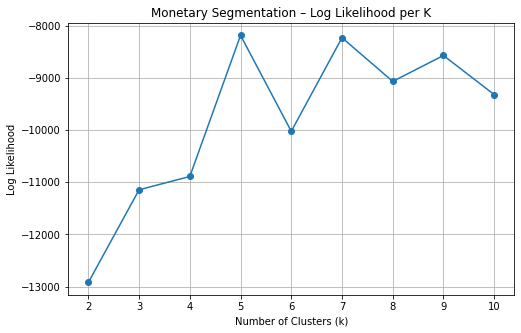

In [0]:
plt.figure(figsize=(8, 5))
plt.plot(log_df["k"], log_df["log_likelihood"], marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Log Likelihood")
plt.title("Monetary Segmentation – Log Likelihood per K")
plt.grid(True)
plt.show()

In [0]:
best_k = 5

gmm_final = GaussianMixture(featuresCol="monetary_scaled", k=best_k)
model_final = gmm_final.fit(df_monetary)
df_monetary_clustered = model_final.transform(df_monetary)

df_monetary_clustered.select("prediction").groupBy("prediction").count().orderBy("count", ascending=False).show()

+----------+-----+
|prediction|count|
+----------+-----+
|         3| 1695|
|         2|  278|
|         4|  233|
|         1|   10|
+----------+-----+



The resulting cluster sizes from the Gaussian Mixture Model are quite unbalanced:

- One cluster (Cluster 3) contains **the vast majority of clients**, suggesting a dominant customer profile.
- Two medium-sized clusters (Clusters 0 and 2) represent **distinct but less common segments**.
- One very small cluster (Cluster 1) contains **only 10 clients**, which may indicate **outliers** or a **very niche high-value group**.

This distribution is typical in real-world datasets, where the majority of customers fall into a general profile, and only a small number exhibit extreme behaviors (e.g., very high spenders).


### Why the Gaussian Mixture Model Returned Only 4 Clusters When k=5

Although we selected **k = 5** based on the Log Likelihood curve — which showed a significant improvement up to k=5 — the Gaussian Mixture Model (GMM) effectively returned **only 4 active clusters**.

This is not an error or a misconfiguration. GMM is a **probabilistic clustering model**, and when fitting the data, it may determine that:
- One of the clusters is **redundant** or overlaps heavily with another.
- The data points assigned to that component have **negligible probability**, causing it to collapse.
- The model **automatically deactivates** that component due to its lack of contribution to the log likelihood.

This behavior reflects the model's attempt to avoid overfitting by removing components that are not statistically meaningful.

Therefore, although we set `k=5`, the model has objectively found that **4 distinct and relevant clusters** describe the monetary segmentation best.

In [0]:
# View the average values per cluster
df_monetary_clustered.groupBy("prediction").mean(*monetary_features).orderBy("prediction").show()

+----------+------------------+-----------------+------------------+------------------+--------------------+--------------------+---------------------+------------------+
|prediction|       avg(Income)| avg(Total_Spend)|     avg(MntWines)|    avg(MntFruits)|avg(MntMeatProducts)|avg(MntFishProducts)|avg(MntSweetProducts)| avg(MntGoldProds)|
+----------+------------------+-----------------+------------------+------------------+--------------------+--------------------+---------------------+------------------+
|         1|          188901.7|            730.4|              21.9|               3.9|               670.3|                 3.6|                 27.3|               3.4|
|         2| 34801.08633093525|36.84892086330935|21.863309352517987|  0.60431654676259|   8.661870503597122|   1.129496402877698|  0.46402877697841727| 4.125899280575539|
|         3| 58341.97168141593|776.9982300884956| 394.0702064896755|33.736283185840705|   211.3976401179941|   48.08967551622419|   34.4519174041

In [0]:
summary_df = df_monetary_clustered.groupBy("prediction").agg(
    *[avg(col).alias(col) for col in monetary_features]
).orderBy("prediction")

# Converter para Pandas
summary_pd = summary_df.toPandas()

# Formatar a tabela
summary_pd.rename(columns={"prediction": "Cluster"}, inplace=True)
summary_pd["Cluster"] = summary_pd["Cluster"].astype(int)
summary_pd.set_index("Cluster", inplace=True)

# Arredondar e forçar uma casa decimal em todos os valores
summary_pd = summary_pd.round(1)
summary_pd = summary_pd.applymap(lambda x: f"{x:.1f}")

# Mostrar tabela apelativa no Databricks
display(summary_pd)


Income,Total_Spend,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
188901.7,730.4,21.9,3.9,670.3,3.6,27.3,3.4
34801.1,36.8,21.9,0.6,8.7,1.1,0.5,4.1
58342.0,777.0,394.1,33.7,211.4,48.1,34.5,55.3
22860.7,46.0,7.9,4.4,11.3,6.6,4.7,11.1


In [0]:
# Variables for profiling (outside of clustering)
profiling_vars = [
    "Education", "Marital_Status", "Kidhome", "Teenhome", "Children",
    "Recency", "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases",
    "NumWebVisitsMonth", "Complain", "AcceptedCampaigns_Total"
]

# Categorical variables
categorical_vars = ["Education", "Marital_Status"]
profiling_categorical = {}

for cat_var in categorical_vars:
    profiling_categorical[cat_var] = (
        df_monetary_clustered.groupBy("prediction", cat_var)
        .agg(count("*").alias("count"))
        .orderBy("prediction", "count", ascending=False)
    )

# Numeric variables
numeric_vars = [v for v in profiling_vars if v not in categorical_vars]

profiling_numeric = (
    df_monetary_clustered.groupBy("prediction")
    .agg(*[avg(col(v)).alias(f"avg_{v}") for v in numeric_vars])
    .orderBy("prediction")
)

# Convert to Pandas and format
profiling_numeric_pd = profiling_numeric.toPandas()
profiling_numeric_pd.rename(columns={"prediction": "Cluster"}, inplace=True)
profiling_numeric_pd.set_index("Cluster", inplace=True)
profiling_numeric_pd = profiling_numeric_pd.round(1)

# Display numeric profiling summary
display(profiling_numeric_pd)


avg_Kidhome,avg_Teenhome,avg_Children,avg_Recency,avg_NumWebPurchases,avg_NumCatalogPurchases,avg_NumStorePurchases,avg_NumWebVisitsMonth,avg_Complain,avg_AcceptedCampaigns_Total
0.4,0.2,0.6,44.0,3.1,10.7,0.6,1.1,0.0,0.0
0.9,0.6,1.6,50.0,1.3,0.1,2.7,6.6,0.0,0.1
0.3,0.5,0.8,49.1,4.9,3.4,6.7,4.9,0.0,0.5
0.8,0.2,1.0,47.2,1.6,0.3,2.8,6.8,0.0,0.2


In [0]:
# Função para converter distribuição categórica em tabela pivotada
def pivot_categorical_distribution(dist_df, cluster_col, category_col):
    # Converter para Pandas
    pdf = dist_df.select(cluster_col, category_col, "percentage").toPandas()
    
    # Pivot da tabela: categorias como colunas, clusters como linhas
    pivot_df = pdf.pivot(index=cluster_col, columns=category_col, values="percentage").fillna(0)
    
    # Arredondar e aplicar formatação percentual
    pivot_df = pivot_df.round(1).applymap(lambda x: f"{x:.1f}%" if x > 0 else "")
    
    # Renomear índice
    pivot_df.index.name = "Cluster"
    return pivot_df

# Aplicar à variável Marital_Status
marital_pivot = pivot_categorical_distribution(marital_dist, "prediction", "Marital_Status")
display(marital_pivot)

# Aplicar à variável Education (se quiseres também)
education_pivot = pivot_categorical_distribution(education_dist, "prediction", "Education")
display(education_pivot)

Absurd,Alone,Divorced,Married,Single,Together,Widow,YOLO
,,10.0%,40.0%,10.0%,40.0%,,
,,9.4%,37.4%,21.9%,28.4%,2.9%,
0.1%,0.2%,10.6%,38.6%,21.2%,25.3%,3.9%,0.1%
,,11.2%,40.8%,21.0%,26.2%,0.9%,


2n Cycle,Basic,Graduation,Master,PhD
,,40.0%,10.0%,50.0%
3.6%,,44.2%,20.1%,32.0%
8.7%,1.1%,50.9%,17.0%,22.4%
18.5%,15.5%,54.5%,8.6%,3.0%


---

### 2. Behavioral & Engagement Segmentation

This segmentation focuses on how customers interact with the company — their preferred channels, purchasing frequency, and responsiveness to marketing.

**Selected features:**
- Purchase channels (`NumWebPurchases`, `NumCatalogPurchases`, etc.)
- Website engagement and recency
- Total accepted campaigns

In [0]:
engagement_features = [
    "NumDealsPurchases", "NumWebPurchases", 
    "NumCatalogPurchases", "NumStorePurchases", 
    "NumWebVisitsMonth", "Website_Engagement", 
    "AcceptedCampaigns_Total", "Recency"
]

# VectorAssembler and StandardScaler
assembler = VectorAssembler(inputCols=engagement_features, outputCol="engagement_vector")
scaler = StandardScaler(inputCol="engagement_vector", outputCol="engagement_scaled")

pipeline = Pipeline(stages=[assembler, scaler])
df_engagement = pipeline.fit(df).transform(df)

In [0]:
# Test several k values using GMM
results = []

for k in range(2, 11):
    gmm = GaussianMixture(featuresCol="engagement_scaled", k=k)
    model = gmm.fit(df_engagement)
    log_likelihood = model.summary.logLikelihood
    results.append((k, log_likelihood))

# Create Pandas DataFrame
import pandas as pd
log_df_eng = pd.DataFrame(results, columns=["k", "log_likelihood"])
display(log_df_eng)

k,log_likelihood
2,13348.349368399005
3,16842.978670808472
4,-21787.86936260629
5,-9190.813030153111
6,-20699.417156200787
7,13918.705555420293
8,-12473.589993728128
9,13626.380259184007
10,19057.519055087814


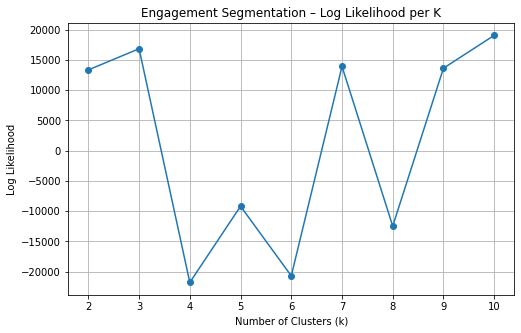

In [0]:
plt.figure(figsize=(8, 5))
plt.plot(log_df_eng["k"], log_df_eng["log_likelihood"], marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Log Likelihood")
plt.title("Engagement Segmentation – Log Likelihood per K")
plt.grid(True)
plt.show()

In [0]:
best_k_eng = 3

gmm_final_eng = GaussianMixture(featuresCol="engagement_scaled", k=best_k_eng)
model_final_eng = gmm_final_eng.fit(df_engagement)
df_engagement_clustered = model_final_eng.transform(df_engagement)

# Quick overview – count per cluster
df_engagement_clustered.select("prediction").groupBy("prediction").count().orderBy("count", ascending=False).show()

+----------+-----+
|prediction|count|
+----------+-----+
|         2| 1600|
|         0|  604|
|         1|   12|
+----------+-----+



In [0]:
# Calcular médias por cluster
summary_df_eng = df_engagement_clustered.groupBy("prediction").agg(
    *[avg(col(f)).alias(f) for f in engagement_features]
).orderBy("prediction")

# Converter para Pandas e formatar
summary_pd_eng = summary_df_eng.toPandas()
summary_pd_eng.rename(columns={"prediction": "Cluster"}, inplace=True)
summary_pd_eng["Cluster"] = summary_pd_eng["Cluster"].astype(int)
summary_pd_eng.set_index("Cluster", inplace=True)

# Arredondar e manter formatação uniforme
summary_pd_eng = summary_pd_eng.round(1)
summary_pd_eng = summary_pd_eng.applymap(lambda x: f"{x:.1f}")

# Mostrar tabela apelativa no Databricks
display(summary_pd_eng)

NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Website_Engagement,AcceptedCampaigns_Total,Recency
2.2,5.1,4.1,6.6,5.0,10.1,1.6,44.1
7.6,6.3,9.0,0.2,8.5,14.8,0.1,47.9
2.3,3.7,2.1,5.5,5.4,9.1,0.0,50.9


In [0]:
def categorical_distribution(df, cluster_col, cat_col):
    total = df.groupBy(cluster_col).agg(count("*").alias("total"))
    count_df = df.groupBy(cluster_col, cat_col).agg(count("*").alias("count"))
    dist = count_df.join(total, cluster_col)
    dist = dist.withColumn("percentage", (col("count") / col("total")) * 100)
    return dist.orderBy(cluster_col, "percentage", ascending=[True, False])

# Distribuição por cluster
marital_dist = categorical_distribution(df_engagement_clustered, "prediction", "Marital_Status")
education_dist = categorical_distribution(df_engagement_clustered, "prediction", "Education")

def pivot_categorical_distribution(dist_df, cluster_col, category_col):
    pdf = dist_df.select(cluster_col, category_col, "percentage").toPandas()
    pivot_df = pdf.pivot(index=cluster_col, columns=category_col, values="percentage").fillna(0)
    pivot_df = pivot_df.round(1).applymap(lambda x: f"{x:.1f}%" if x > 0 else "")
    pivot_df.index.name = "Cluster"
    return pivot_df

marital_pivot = pivot_categorical_distribution(marital_dist, "prediction", "Marital_Status")
education_pivot = pivot_categorical_distribution(education_dist, "prediction", "Education")

display(marital_pivot)
display(education_pivot)

Absurd,Alone,Divorced,Married,Single,Together,Widow,YOLO
0.2%,0.2%,11.4%,35.8%,24.3%,23.7%,4.3%,0.2%
,,8.3%,41.7%,25.0%,25.0%,,
0.1%,0.1%,10.1%,39.8%,20.1%,26.7%,3.1%,0.1%


2n Cycle,Basic,Graduation,Master,PhD
7.5%,1.2%,49.0%,16.4%,26.0%
,,41.7%,,58.3%
9.7%,2.9%,50.9%,16.6%,19.8%


In [0]:
profiling_vars_clean = ["Kidhome", "Teenhome", "Children", "Complain"]
profiling_numeric = (
    df_engagement_clustered.groupBy("prediction")
    .agg(*[avg(col(v)).alias(f"avg_{v}") for v in profiling_vars_clean])
    .orderBy("prediction")
)

profiling_numeric_pd = profiling_numeric.toPandas()
profiling_numeric_pd.rename(columns={"prediction": "Cluster"}, inplace=True)
profiling_numeric_pd.set_index("Cluster", inplace=True)
profiling_numeric_pd = profiling_numeric_pd.round(1)
display(profiling_numeric_pd)

avg_Kidhome,avg_Teenhome,avg_Children,avg_Complain
0.3,0.4,0.7,0.0
0.2,0.6,0.8,0.0
0.5,0.5,1.0,0.0


---

## 3. Promo Response Segmentation

This segmentation focuses on how customers respond to promotions and marketing campaigns — including their sensitivity to discounts, recency of activity, and overall promotional engagement.

**Selected features:**
- Campaign response (`AcceptedCampaigns_Total`)
- Promotion-driven purchases (`NumDealsPurchases`)
- Customer complaints (`Complain`)
- Recency (days since last purchase)


In [0]:
# Define final features for Promo Response Segmentation
promo_features = [
    "AcceptedCampaigns_Total", "NumDealsPurchases",
    "Complain", "Recency"
]

# Preparation pipeline
assembler = VectorAssembler(inputCols=promo_features, outputCol="promo_vector")
scaler = StandardScaler(inputCol="promo_vector", outputCol="promo_scaled")
pipeline = Pipeline(stages=[assembler, scaler])
df_promo = pipeline.fit(df).transform(df)

# Log Likelihood for k = 2 to 10
results = []
for k in range(2, 11):
    gmm = GaussianMixture(featuresCol="promo_scaled", k=k)
    model = gmm.fit(df_promo)
    log_likelihood = model.summary.logLikelihood
    results.append((k, log_likelihood))

log_df_promo = pd.DataFrame(results, columns=["k", "log_likelihood"])
display(log_df_promo)

k,log_likelihood
2,12440.222007512411
3,10754.5584227257
4,42703.31085843341
5,8594.37455150414
6,-3472.5791712937703
7,20427.836533658756
8,19281.30158796102
9,15987.13284630148
10,23313.258949620093


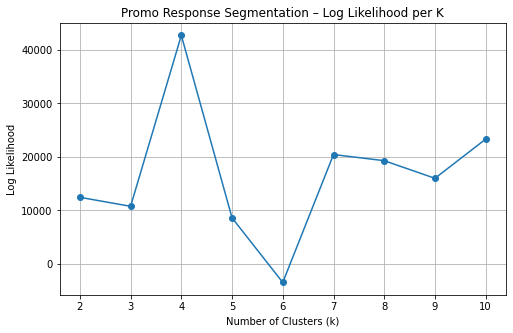

In [0]:
plt.figure(figsize=(8, 5))
plt.plot(log_df_promo["k"], log_df_promo["log_likelihood"], marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Log Likelihood")
plt.title("Promo Response Segmentation – Log Likelihood per K")
plt.grid(True)
plt.show()


In [0]:
best_k_promo = 4

gmm_final_promo = GaussianMixture(featuresCol="promo_scaled", k=best_k_promo)
model_final_promo = gmm_final_promo.fit(df_promo)
df_promo_clustered = model_final_promo.transform(df_promo)

# Quick overview – count per cluster
df_promo_clustered.select("prediction").groupBy("prediction").count().orderBy("count", ascending=False).show()

+----------+-----+
|prediction|count|
+----------+-----+
|         3| 1861|
|         0|  289|
|         1|   45|
|         2|   21|
+----------+-----+



In [0]:
# Calcular médias por cluster
summary_df_promo = df_promo_clustered.groupBy("prediction").agg(
    *[avg(col(f)).alias(f) for f in promo_features]
).orderBy("prediction")

# Converter para Pandas e formatar
summary_pd_promo = summary_df_promo.toPandas()
summary_pd_promo.rename(columns={"prediction": "Cluster"}, inplace=True)
summary_pd_promo["Cluster"] = summary_pd_promo["Cluster"].astype(int)
summary_pd_promo.set_index("Cluster", inplace=True)

# Arredondar e manter formatação uniforme
summary_pd_promo = summary_pd_promo.round(1)
summary_pd_promo = summary_pd_promo.applymap(lambda x: f"{x:.1f}")

# Mostrar no Databricks
display(summary_pd_promo)

AcceptedCampaigns_Total,NumDealsPurchases,Complain,Recency
2.2,1.2,0.0,53.3
0.6,10.0,0.0,35.4
0.3,2.3,1.0,53.0
0.2,2.3,0.0,48.6


In [0]:
profiling_vars_promo = [
    "Age", "Income", "Kidhome", "Teenhome", "Children",
    "Education", "Marital_Status"
]

def categorical_distribution(df, cluster_col, cat_col):
    total = df.groupBy(cluster_col).agg(count("*").alias("total"))
    count_df = df.groupBy(cluster_col, cat_col).agg(count("*").alias("count"))
    dist = count_df.join(total, cluster_col)
    dist = dist.withColumn("percentage", (col("count") / col("total")) * 100)
    return dist.orderBy(cluster_col, "percentage", ascending=[True, False])

# Education e Marital_Status
education_dist_promo = categorical_distribution(df_promo_clustered, "prediction", "Education")
marital_dist_promo = categorical_distribution(df_promo_clustered, "prediction", "Marital_Status")

def pivot_categorical_distribution(dist_df, cluster_col, category_col):
    pdf = dist_df.select(cluster_col, category_col, "percentage").toPandas()
    pivot_df = pdf.pivot(index=cluster_col, columns=category_col, values="percentage").fillna(0)
    pivot_df = pivot_df.round(1).applymap(lambda x: f"{x:.1f}%" if x > 0 else "")
    pivot_df.index.name = "Cluster"
    return pivot_df

education_pivot = pivot_categorical_distribution(education_dist_promo, "prediction", "Education")
marital_pivot = pivot_categorical_distribution(marital_dist_promo, "prediction", "Marital_Status")

display(education_pivot)
display(marital_pivot)

2n Cycle,Basic,Graduation,Master,PhD
5.9%,0.7%,50.9%,15.6%,27.0%
4.4%,,40.0%,24.4%,31.1%
19.0%,,66.7%,9.5%,4.8%
9.5%,2.8%,50.3%,16.5%,20.8%


Absurd,Alone,Divorced,Married,Single,Together,Widow,YOLO
0.3%,0.3%,10.4%,39.4%,24.2%,20.8%,4.5%,
,,13.3%,40.0%,17.8%,24.4%,4.4%,
,,9.5%,38.1%,28.6%,23.8%,,
0.1%,0.1%,10.4%,38.5%,20.8%,26.7%,3.3%,0.1%


In [0]:
numeric_vars = ["Age", "Income", "Kidhome", "Teenhome", "Children"]

profiling_numeric_promo = (
    df_promo_clustered.groupBy("prediction")
    .agg(*[avg(col(v)).alias(f"avg_{v}") for v in numeric_vars])
    .orderBy("prediction")
)

profiling_numeric_promo_pd = profiling_numeric_promo.toPandas()
profiling_numeric_promo_pd.rename(columns={"prediction": "Cluster"}, inplace=True)
profiling_numeric_promo_pd.set_index("Cluster", inplace=True)
profiling_numeric_promo_pd = profiling_numeric_promo_pd.round(1)

display(profiling_numeric_promo_pd)

avg_Age,avg_Income,avg_Kidhome,avg_Teenhome,avg_Children
44.9,70271.3,0.2,0.2,0.4
49.0,55131.3,0.8,1.0,1.8
48.9,45242.3,0.7,0.5,1.2
45.1,49457.6,0.5,0.5,1.0
